# Artificial Neural Networks

In [1]:
import numpy as np
seed = 42
rng = np.random.default_rng(seed=seed)

## Network Class

We shall start writing the `Network` class. The two methods that are indispensable for any ML class are :
- `fit`
- `predict`

Fitting a neural network model requires us to compute two passes on the data :
- `forward`
- `backward`

We need to start at some place by initializing the network and various hyperparameters and this requires an `init` method :
- `init`

In most of these methods, we would have to take the help of certain helper functions :
- `activations`
- `losses`

This is the process. But we will work through it in the reverse order so that each step of the process does not have any forward references :
`helpers -> init -> forward -> backward -> fit -> predict`

The skeleton of the class is given in the code block that follows. For ease of exposition, we are going to discuss the methods on at a time and then plugh them into the class right at the end.

In [2]:
class Network :
    
    def __init__(self, layers, activation_choice="relu", output_choice="softmax", loss_choice="cce") :
        pass
    
    def forward(self, X) :
        pass
    
    def backward(self, Y, Y_hat) :
        pass
    
    def fit(self, X, Y, lr=0.01, epochs=100, batch_size=100) :
        pass
    
    def predict(self, X) :
        pass

## Activation Functions

### Hidden Layer

We will look at 2 functions for the hidden layers. Both of these functions will be **applied element-wise**. The input to these functions can be scalars, vectors or matrices

- Sigmoid :
$$
    g(z) = \frac {1} {1 + e^{-z}}
$$

Its derivative :

$$
    g'(z) = g(z)(1 - g(z))
$$

- ReLU ( Rectified Linear Unit ) :
$$
    g(x)=\begin{cases}
    z, & z \ge 0 \\ 
    0, & z<0
    \end{cases}
$$

Its derivative :

$$
    g'(x)=\begin{cases}
    1, & z \ge 0 \\ 
    0, & z<0
    \end{cases}
$$


In [3]:
def sigmoid(z) :
    return 1 / (1 + np.exp(-z))

def grad_sigmoid(z) :
    return sigmoid(z) * (1 - sigmoid(z))

def relu(z) :
    return np.where(z >= 0, z, 0)

def grad_relu(z) :
    return np.where(z >= 0, 1, 0)


# A dictionary of activation functions will be used while initializing the network
hidden_act = {"sigmoid": sigmoid, "relu": relu}
grad_hidden_act = {"sigmoid": grad_sigmoid, "relu": grad_relu}

## Output Layer

We will look at 2 activation functions for the output layer :
    
- Identity ( For regression )
$$
    g(z) = z
$$

- Softmax ( For classification ) :
The input to the softmax function will always be a matrix of size $n \times k$. Since we need a probability distribution for each data point, **the softmax will be computed row-wise**

$$
    g(\textbf Z) = 
    \begin{pmatrix}
    ... & ... & ... \\
    ... & \frac {e^{Z_{ij}}} {\sum \limits_{j=1}^{k} e^{Z_{ij}}} & ... \\
    ... & ... & ... \\
    \end{pmatrix}
$$

**To avoid overflow, we will subtract the row-wise maximum from each row while computing the softmax**

In [4]:
def identity(z) :
    return z

def softmax(z) :
    """
    Row-wise softmax
    """
    # Check if z is a matrix
    assert z.ndim == 2
    
    # To prevent overflow, subtract row-wise maximum
    z -= z.max(axis=1, keepdims=True)
    
    # Compute row-wise softmax
    prob = np.exp(z) / np.exp(z).sum(axis=1, keepdims=True)
    
    # Check if each row is a probability distribution
    assert np.allclose(prob.sum(axis=1), np.ones(z.shape[0]))
    
    return prob

output_act = {"softmax": softmax, "identity": identity}

## Loss

We will use 2 types of losses :

- Least Square Loss ( For Regression ) :

$$
    L(\hat {\textbf y}, \textbf y) = \frac {1} {2} (\hat {\textbf y} - \textbf y)^{T}(\hat {\textbf y} - \textbf y)
$$

- Categorial Cross-Entropy Loss ( For Classification ) :
    
$$
    L(\hat {\textbf Y}, \textbf Y) = - \textbf 1_{n}^T(\textbf Y \odot log(\hat {\textbf Y})\textbf1-{k}
$$

In our implementation, we will assume that the arguments to the loss function are always matrices of size $n \times k$. In the case of regression, $k = 1$.

In [5]:
def least_squares(y, y_hat) :
    return 0.5 * np.sum((y_hat - y) * (y_hat - y))

def cce(Y, Y_hat) :
    return -np.sum(Y * np.log(Y_hat))

losses = {"least_squares": least_squares, "cce": cce}

## Initialization

Here, we will look at two parts :

### Network architecture

The following components mainly determine the structure of the network :
- Number of layers
- Number of neuron per layer
We will use $l$ to index the layers. The network has $L$ layers in all.
- $l = 0$ : Input layer
- $1 \le l \le L - 1$ : Hidden layers
- $l = L$ : Output layer

We shall represent the number of layers and neurons using a list `layers`. The variable $L$ will never make an explicit appearance anywhere, instead will use `range(len(layers))` to iterate through the layers.

| Layer           | Number of neurons |
| -----------     | -----------       |
| Input layer     | `layers[0]`       |
| Hidden layer 1  | `layers[1]`       |
| Hidden layer 2  | `layers[2]`       |
| Hidden layer 3  | `layers[3]`       |
| **.......**     | `layers[...]`     |
| Output layer    | `layers[-1]`      |

One useful task is to compute the total number of parameters in each network. This will come handy later on.

In [6]:
def count_params(layers) :
    num_params = 0
    for l in range(1, len(layers)) :
        num_weights = layers[l - 1] * layers[l]
        num_biases = layers[l]
        num_params += (num_weights + num_biases)
    return num_params

### Parameter initialization

- The weight matrix at layer $l$ has a size of `layers[l - 1] x layers[l]`
- The bias at layer $l$ is a vector of size `layers[l]`
- We will store all these weights in a list `w` of the same size as `layers`. So, `W[l]` will correspond to $\textbf W_l$. Since there are $L$ weight matrices `W[0]` would be set to `None`. Recall that size of the list if $L + 1$
- A similar list would be required for `b`

To make the gradient descent update simpler, it will be useful to have a **master vector, $\boldsymbol \theta$, that has a refernce to all the parameters in the network**. We will do the same for the gradients $\boldsymbol \theta^{(g)}$. So, whenever $\boldsymbol \theta$ is updated, the weights $\textbf W_l$ will also be updated and vice-versa

One way to do that is to first start with the master vector and then reshape chunks of it into the dimensions of a weight matrix matrix. Reshaping as arrays usually returns a view of an array and not a copy. Visit [this link](https://numpy.org/doc/stable/user/basics.copies.html) to know more.

In [7]:
def init_params(layers) :
    num_params = count_params(layers)
    
    W = [None for _ in range(len(layers))]
    b = [None for _ in range(len(layers))]
    gW = [None for _ in range(len(layers))]
    gb = [None for _ in range(len(layers))]
    
    
    # Sample for N(0, 1) to initialize the parameters
    
    theta = rng.standard_normal(num_params) # Master params
    gtheta = np.zeros(num_params) # Master grads
    
    # (start, end) specify the portion of the theta that 
    # corresponds to the parameter, W_l ot b_l
    start, end = 0, 0
    
    for l in range(1, len(layers)) :
        # Reshaping the section (start, end) and assign it to W[l]
        end = start + layers[l - 1] * layers[l]
        W[l] = theta[start: end].reshape(layers[l - 1], layers[l])
        gW[l] = gtheta[start: end].reshape(layers[l - 1], layers[l])
        
         # Reshaping the section (start, end) and assign it to b[l]
        start, end = end, end + layers[l]
        b[l] = theta[start: end].reshape(layers[l])
        gb[l] = gtheta[start: end].reshape(layers[l])
        
        start = end
        
    return theta, gtheta, W, b, gW, gb

We are now ready to initialize the network

In [8]:
def init(self, layers, activation_choice="relu", output_choice="softmax", loss_choice="cce") :
    
    self.layers = layers
    
    # Parameters and gradients
    self.theta, self.gtheta, self.W, self.b, self.gW, self.gb = init_params(layers)
    
    # Activation functions
    self.ghid = hidden_act[activation_choice]
    self.grad_ghid = grad_hidden_act[activation_choice]
    self.gout = output_act[output_choice]
    
    # Loss
    self.loss = losses[loss_choice]

## Forward Pass

The forward pass algorithm is as follows. First, we initialize $\textbf A_0 = \textbf X$. Then, we iteratively compute the pre-activations and the activations for every layer $l$ using the equations given below :

$$
    \textbf Z_l = \textbf A_{l-1}\textbf W_{l} + \textbf b_{l}
$$

$$
    \textbf A_l = g(\textbf Z_l)
$$

Finally, the network's output is given by : $\hat {\textbf y} = \textbf A_L$

In [9]:
def forward(self, X) :
    self.Z = [None for _ in range(len(self.layers))]
    self.A = [None for _ in range(len(self.layers))]
    self.A[0] = X
    self.Z[0] = X
    
    for l in range(1, len(self.layers)) :
        self.Z[l] = self.A[l - 1] @ self.W[l] + self.b[l]
        self.A[l] = self.ghid(self.Z[l])
            
    self.A[-1] = self.gout(self.Z[-1])
    return self.A[-1]

## Backward Pass

The backward pass algorithm is as follows. We first initialize the gradients at layer $L$ as $\textbf Z_L^{(g)} = \hat {\textbf Y} - \textbf Y$. It is fortunate that this is true for both regression and classification. The other gradients can then be iteratively updated using these equations :

**NOTATION** : $ \textbf V_{l}^{(g)}$ denotes the gradient of $\textbf V$ at layer $l$

<br>

$$
    \textbf W_l^{(g)} = \textbf A_{l-1}^{T}\textbf Z_{l}^{(g)}
$$

<br>

$$
    \textbf b_l^{(g)} = \textbf Z_{l}^{(g)^T}\textbf 1_{n}
$$

<br>

$$
    \textbf A_{l-1}^{(g)} = \textbf Z_{l}^{(g)}\textbf W_{l}^{T}
$$

<br>

$$
    \textbf Z_{l-1}^{(g)} = \textbf A_{l-1}^{(g)} \odot g'(\textbf Z_{l-1})
$$

<br>

An important point to note is the use of `self.gw[1][:, :]` while updating the gradient of the weights and not `self.gW[1]`. `self.gw[1][:, :]` does an in-place update, thus maintaining a link with the master params namely `self.theta`.

In [10]:
def backward(self, Y, Y_hat) :
    gZ = [None for _ in range(len(self.layers))]
    gA = [None for _ in range(len(self.layers))]
    gZ[-1] = Y_hat - Y
    
    for l in range(len(self.layers) - 1, 0, -1) :
        self.gW[l][:, :] = self.A[l - 1].T @ gZ[l]
        self.gb[l][:] = np.sum(gZ[l].T, axis=1)
        gA[l - 1] = gZ[l] @ self.W[l].T
        gZ[l - 1] = gA[l - 1] * self.grad_ghid(self.Z[l - 1])

## Fit

We now have all the ingredients to fit a model using gradient descent. We will use **mini-batch gradient descent**. The batch-size, learning rate and number of epochs will be hyper-parameters.

In [11]:
def fit(self, X, Y, lr=0.01, epochs=100, batch_size=100) :
    self.losses = []
    
    for epoch in range(epochs) :
        # Compute the loss
        Y_hat = self.forward(X)
        self.losses.append(self.loss(Y, Y_hat))
        
        # Shuffle the dataset
        indices = np.arange(X.shape[0])
        
        # Use rng.shuffle to maintain reproducibility
        rng.shuffle(indices)
        X, Y = X[indices], Y[indices]
        
        # Number of batched
        num_batches = X.shape[0] // batch_size
        
        # Mini-batch GD
        for b in range(num_batches) :
            Xb = X[b * batch_size : (b + 1) * batch_size]
            Yb = Y[b * batch_size : (b + 1) * batch_size]
    
            # Compute the predictions for this batch
            Y_hatb = self.forward(Xb)
            
            # Compute the gradients for this batch
            self.backward(Yb, Y_hatb)
            
            # Update the gradients of all parameters. 
            # -= is used for in-place update
            self.theta -= lr * self.gtheta

## Predict

Finally, we can use a trained model to predict the labels

In [12]:
def predict(self, X) :
    Y_hat = self.forward(X)
    
    if(X.shape[-1] == -1) :
        # Regression
        return Y_hat
    else :
        # Classification
        return np.argmax(Y_hat, axis=1)

## Pluggin in

We can now plug all of this into our `Network` class

In [13]:
Network.__init__ = init
Network.forward = forward
Network.backward = backward
Network.fit = fit
Network.predict = predict

## Testing

### Data

We will import the digits dataset from `sklearn`

Sample image with label :  0
(1797, 8, 8)


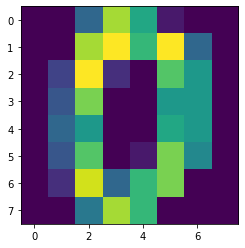

In [14]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits = load_digits()

X = digits.images
y = digits.target

# Normalize the data so that all the features lie in (0, 1)
X /= np.max(X)

plt.imshow(X[0])
print("Sample image with label : ", y[0])
print(X.shape)

# Reshape input
X = X.reshape(-1, 64)

# Input size
isize = X.shape[-1]

# Output size
osize = len(np.unique(y))

In [15]:
def onehot_encoder(y) :
    k = len(np.unique(y))
    return np.eye(k)[y]

In [16]:
from sklearn.model_selection import train_test_split

# ranfom_state has the same seed value as rng

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed)

Y_train = onehot_encoder(y_train)
Y_test = onehot_encoder(y_test)

print("Training data shape : ", X_train.shape, Y_train.shape)
print("Test data shape : ", X_test.shape, Y_test.shape)

Training data shape :  (1078, 64) (1078, 10)
Test data shape :  (719, 64) (719, 10)


Test data size :  719
Accuracy :  96.3839
Number of parameters :  2410


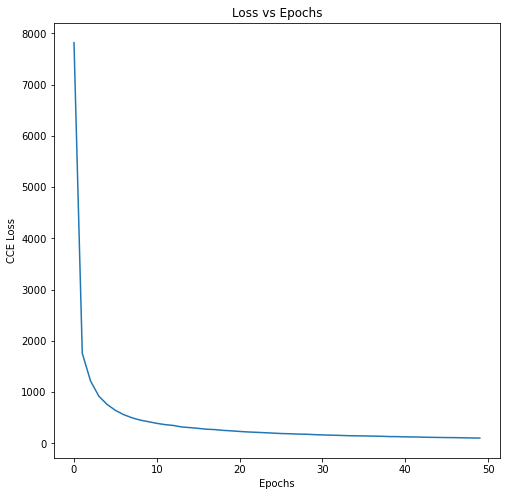

In [19]:
# Initialize the network
layers = [isize, 32, osize]
network = Network(layers, activation_choice="sigmoid", output_choice="softmax", loss_choice="cce")

# Fit the network on data
epochs = 50
network.fit(X_train, Y_train, lr=0.01, epochs=epochs, batch_size=10)

# Plot the losses

plt.figure(figsize=(8,8))
plt.plot(range(epochs), network.losses)
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("CCE Loss")


# Compute the accuracy
y_hat = network.predict(X_test)
accuracy = (np.sum(y_hat == y_test) / X_test.shape[0]) * 100

print("Test data size : ", X_test.shape[0])
print("Accuracy : ", round(accuracy, 4))
print("Number of parameters : ", count_params(layers))